In [1]:
%load_ext autoreload
%autoreload 2

from typing import Tuple

import numpy as np
import tensorflow as tf

from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt

from dataloader.data_generator import DataGenerator
from dataloader.ds_pairs import get_pairwise_dataset
from models.feature_model import IMAGE_SIZE_EFFICIENTNET
from models.image_matcher import ImageMatcher
from models.metrics import get_roc_auc_curve_metrics
from train import DATA_DIRPATH, BATCH_SIZE, IMAGE_SIZE_DATASET, VAL_SPLIT, TEST_SPLIT
from utils.helper import load_config
from utils.plot import plot_roc_auc_curve


CONFIG_FILEPATH = "config.yaml"

## User-input: `MODEL_FILEPATH`

In [2]:
MODEL_FILEPATH = Path("saved_models/efficientnet_ffblocks_2_emb_1024/")
assert MODEL_FILEPATH.is_dir()

# Create an instance of `ImageMatcher`

In [3]:
image_matcher = ImageMatcher(model_filepath=MODEL_FILEPATH)

image_matcher.model.summary()

2023-01-10 11:44:51.608259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 11:44:51.608610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "image_matching"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 icingOpLambda)                                        

# Verify that the embeddings accurately discriminate different classes of images

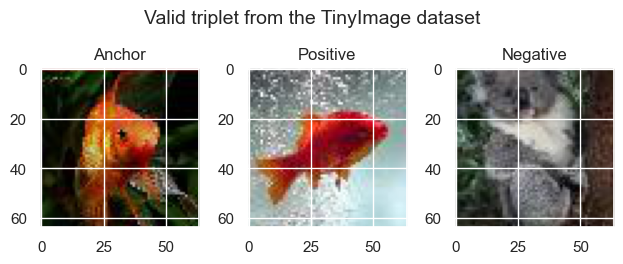

In [4]:
list_img_filepaths = [
    "tiny-imagenet-200/train/n01443537/images/n01443537_4.JPEG",
    "tiny-imagenet-200/train/n01443537/images/n01443537_10.JPEG",
    "tiny-imagenet-200/train/n01882714/images/n01882714_2.JPEG"
]

with Image.open(list_img_filepaths[0]) as im:
    anchor = np.array(im)

with Image.open(list_img_filepaths[1]) as im:
    positive = np.array(im)

with Image.open(list_img_filepaths[2]) as im:
    negative = np.array(im)

fig, axis = plt.subplots(1, 3)
axis[0].imshow(anchor)
axis[0].set_title("Anchor")
axis[1].imshow(positive)
axis[1].set_title("Positive")
axis[2].imshow(negative)
axis[2].set_title("Negative")

fig.suptitle("Valid triplet from the TinyImage dataset", fontsize=14, y=0.75)
fig.tight_layout()

# triplet_loss_example_filepath = Path("report/figs/triplet_loss/valid_triplet.png")
# triplet_loss_example_filepath.parent.mkdir(parents=True, exist_ok=True)
# fig.savefig(triplet_loss_example_filepath)

In [5]:
output_1 = image_matcher.predict(anchor, positive)
output_1

2023-01-10 11:45:13.117721: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-10 11:45:13.124980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 11:45:14.433462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 11:45:14.486008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.03183275], dtype=float32)>

In [6]:
output_2 = image_matcher.predict(anchor, negative)
output_2

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.5196313], dtype=float32)>

In [7]:
margin = 1
assert output_1 > output_2 + margin
print("The model is a priori well trained.")

The model is a priori well trained.


# Load the `DataGenerator`

In [8]:
config = load_config(CONFIG_FILEPATH)

data_generator = DataGenerator(
    directory=DATA_DIRPATH,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE_DATASET,
    shuffle=True,
    seed=config["seed"],
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT
)

Found 100000 files belonging to 200 classes.
Using 70000 files for training.
Using 30000 files for validation.


# Create the pairwise dataset

In [9]:
ds_pairs = get_pairwise_dataset(data_generator.test_unbatched.shuffle(buffer_size=1000),
                                image_size=IMAGE_SIZE_EFFICIENTNET)
ds_pairs = ds_pairs.batch(32)

## User-input: `N_BATCHES`

Because the dataset is composed of all pairs of images from the test set, we will have $\binom{n}{2}$ instances with $n = Card(\text{testset})$. For $n=10000$, this would amount to $49995000$ examples. Therefore, we will only evaluate our model on a fraction of the test set by specifying the number of 32-example batches we want to use.

In [10]:
N_BATCHES = 1000

# Evaluate the E2E model

In [11]:
image_matcher.get_auc(ds_pairs.take(N_BATCHES), steps=N_BATCHES)

2023-01-10 11:45:21.501769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 585s 581ms/step - loss: 0.0000e+00 - auc: 0.8997


0.8996557593345642

# Plot AUC ROC Curve

In [12]:
fpr, tpr, thresholds, roc_auc = get_roc_auc_curve_metrics(image_matcher, ds_pairs, n_batches=N_BATCHES)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:42<00:00,  1.56it/s]


Figure was successfully saved at `logs/efficientnet_ffblocks_2_emb_1024/roc_auc.png`.


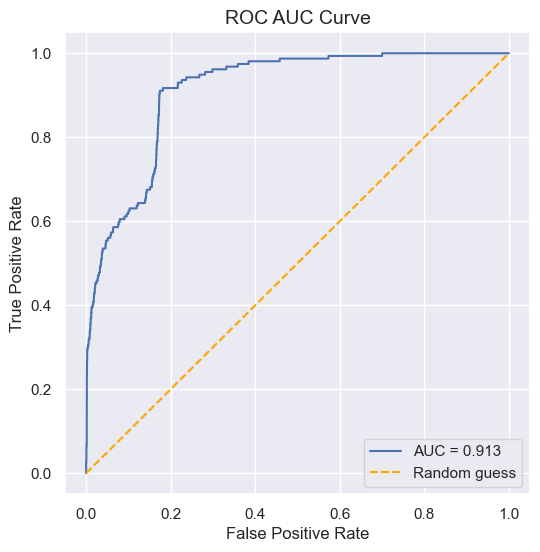

In [13]:
model_experiment = MODEL_FILEPATH.stem
roc_auc_fig_savepath = f"logs/{model_experiment}/roc_auc.png"

plot_roc_auc_curve(fpr, tpr, roc_auc, fig_savepath=roc_auc_fig_savepath)

print(f"Figure was successfully saved at `{roc_auc_fig_savepath}`.")